In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, mean_squared_error
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from itertools import product

warnings.filterwarnings("ignore")


In [14]:
def load_dataset(scaler="minmax", strategy="split"):
    """
    Carrega os datasets NSL-KDD com duas estratégias:
    - 'split': carrega apenas o arquivo de treino e faz split em treino e validação
    - 'merge': carrega treino e teste reais e faz codificação alinhada
    """
    assert scaler in ["minmax", "standard"], "Escala inválida"
    assert strategy in ["split", "merge"], "Estratégia deve ser 'split' ou 'merge'"
    
    base_path = f"../data/final/{scaler}"
    train_path = f"{base_path}/KDDTrain+_final_{scaler}.csv"
    test_path = f"{base_path}/KDDTest+_final_{scaler}.csv"

    if strategy == "split":
        df = pd.read_csv(train_path)
        print(f"[SPLIT] Escala usada: {scaler}")
        print("Dataset carregado:", df.shape)

        # Split em treino e validação
        df_train, df_test = train_test_split(
            df, test_size=0.2, random_state=1, stratify=df["attack_category"]
        )
        print("Train split:", df_train.shape)
        print("Validação split:", df_test.shape)

        return df_train.reset_index(drop=True), df_test.reset_index(drop=True)

    else:  # strategy == "merge"
        df_train = pd.read_csv(train_path)
        df_test = pd.read_csv(test_path)

        df_train["__origin__"] = "train"
        df_test["__origin__"] = "test"

        df_all = pd.concat([df_train, df_test], axis=0)

        origin = df_all["__origin__"]
        target = df_all["attack_category"]
        df_all = df_all.drop(columns=["__origin__", "attack_category"])

        df_all = pd.get_dummies(df_all)
        df_all = df_all.fillna(0)

        df_all["attack_category"] = target.values
        df_all["__origin__"] = origin.values

        df_train_final = df_all[df_all["__origin__"] == "train"].drop(columns="__origin__")
        df_test_final = df_all[df_all["__origin__"] == "test"].drop(columns="__origin__")

        print(f"[MERGE] Escala usada: {scaler}")
        print("Train final:", df_train_final.shape)
        print("Test final :", df_test_final.shape)

        return df_train_final.reset_index(drop=True), df_test_final.reset_index(drop=True)

In [15]:
# minmax or standard
# Estratégia de split (KDDTrain+ somente)

df_train, df_val = load_dataset("minmax", strategy="split")

X_train = df_train.drop(columns=["attack_category"])
y_train = df_train["attack_category"]

X_val = df_val.drop(columns=["attack_category"])
y_val = df_val["attack_category"]

# Estratégia para avaliação final real (KDDTrain+ e KDDTest+ juntos)
df_train_final, df_test_final = load_dataset("minmax", strategy="merge")

X_train_final = df_train_final.drop(columns=["attack_category"])
y_train_final = df_train_final["attack_category"]

X_test_final = df_test_final.drop(columns=["attack_category"])
y_test_final = df_test_final["attack_category"]

[SPLIT] Escala usada: minmax
Dataset carregado: (125973, 62)
Train split: (100778, 62)
Validação split: (25195, 62)
[MERGE] Escala usada: minmax
Train final: (125973, 64)
Test final : (22544, 64)


## 3. Decision Tree

In [16]:
def run_grid_search(X, y, model, param_grid, cv=3, scoring='f1_macro'):
    grid = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        scoring=scoring,
        cv=cv,
        verbose=3,
        n_jobs=-1,
        return_train_score=True
    )
    
    start = time.time()
    grid.fit(X, y)
    duration = time.time() - start

    results_df = pd.DataFrame(grid.cv_results_)
    results_df = results_df.sort_values(by="mean_test_score", ascending=False)

    print("\nMelhores parâmetros encontrados:")
    for k, v in grid.best_params_.items():
        print(f"  {k}: {v}")
    print(f"\nMelhor {scoring}: {grid.best_score_:.4f}")
    print(f"Tempo total: {duration:.2f} segundos")

    display_columns = [
        'mean_test_score', 'mean_train_score', 'std_test_score'
    ] + [col for col in results_df.columns if col.startswith('param_')]

    print("\nTop 10 combinações:")
    display(results_df[display_columns].head(10))

    return grid, results_df


In [18]:
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 30],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 4],
    'max_features': [None, 'sqrt'],
    'ccp_alpha': [0.0, 0.25, 0.5],
}

dt_model = DecisionTreeClassifier(random_state=1)

grid, results_df = run_grid_search(X_train, y_train, dt_model, param_grid_dt)


Fitting 3 folds for each of 96 candidates, totalling 288 fits
[CV 2/3] END ccp_alpha=0.0, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2;, score=(train=0.809, test=0.819) total time=   0.4s
[CV 1/3] END ccp_alpha=0.0, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2;, score=(train=0.840, test=0.804) total time=   0.4s
[CV 3/3] END ccp_alpha=0.0, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=2;, score=(train=0.833, test=0.768) total time=   0.4s
[CV 1/3] END ccp_alpha=0.0, criterion=gini, max_depth=10, max_features=sqrt, min_samples_leaf=1, min_samples_split=10;, score=(train=0.825, test=0.767) total time=   0.5s
[CV 3/3] END ccp_alpha=0.0, criterion=gini, max_depth=10, max_features=None, min_samples_leaf=1, min_samples_split=10;, score=(train=0.920, test=0.908) total time=   0.9s
[CV 1/3] END ccp_alpha=0.0, criterion=gini, max_depth=10, max_features=None, min_sampl

,mean_test_score,mean_train_score,std_test_score,param_ccp_alpha,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split
11,0.918959,0.944968,0.005592,0.0,gini,30,None,4,10
8,0.915556,0.998818,0.007634,0.0,gini,30,None,1,2
9,0.914417,0.968518,0.012690,0.0,gini,30,None,1,10
28,0.908865,0.998818,0.015045,0.0,entropy,30,sqrt,1,2
10,0.908800,0.946394,0.015761,0.0,gini,30,None,4,2
16,0.906985,0.965484,0.017211,0.0,entropy,10,None,1,2
17,0.906670,0.952040,0.024094,0.0,entropy,10,None,1,10
25,0.903447,0.965920,0.023207,0.0,entropy,30,None,1,10
1,0.903355,0.930336,0.007254,0.0,gini,10,None,1,10
3,0.903111,0.916777,0.000951,0.0,gini,10,None,4,10


In [19]:
param_grid_dt_2 = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [25, 30, 35, 40],
    'min_samples_leaf': [3, 4, 5, 6],
    'min_samples_split': [8, 10, 12],
    'max_features': [None, 'sqrt'],
    'ccp_alpha': [0.0, 0.001, 0.005]
}
dt_model = DecisionTreeClassifier(random_state=1)

grid, results_df = run_grid_search(X_train, y_train, dt_model, param_grid_dt_2)

Fitting 3 folds for each of 576 candidates, totalling 1728 fits
[CV 2/3] END ccp_alpha=0.0, criterion=gini, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=8;, score=(train=0.950, test=0.918) total time=   1.1s
[CV 1/3] END ccp_alpha=0.0, criterion=gini, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=8;, score=(train=0.948, test=0.887) total time=   1.2s
[CV 3/3] END ccp_alpha=0.0, criterion=gini, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=8;, score=(train=0.953, test=0.937) total time=   1.2s
[CV 2/3] END ccp_alpha=0.0, criterion=gini, max_depth=25, max_features=None, min_samples_leaf=3, min_samples_split=10;, score=(train=0.944, test=0.924) total time=   1.2s
[CV 1/3] END ccp_alpha=0.0, criterion=gini, max_depth=25, max_features=None, min_samples_leaf=4, min_samples_split=8;, score=(train=0.947, test=0.887) total time=   1.1s
[CV 2/3] END ccp_alpha=0.0, criterion=gini, max_depth=25, max_features=None, min_samp

,mean_test_score,mean_train_score,std_test_score,param_ccp_alpha,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split
49,0.925399,0.948067,0.009958,0.0,gini,35,None,3,10
73,0.925399,0.948067,0.009958,0.0,gini,40,None,3,10
25,0.925399,0.948067,0.009958,0.0,gini,30,None,3,10
1,0.925399,0.948067,0.009958,0.0,gini,25,None,3,10
50,0.921875,0.945576,0.005071,0.0,gini,35,None,3,12
26,0.921875,0.945576,0.005071,0.0,gini,30,None,3,12
2,0.921875,0.945576,0.005071,0.0,gini,25,None,3,12
74,0.921875,0.945576,0.005071,0.0,gini,40,None,3,12
52,0.918959,0.944968,0.005592,0.0,gini,35,None,4,10
76,0.918959,0.944968,0.005592,0.0,gini,40,None,4,10


### Melhor Modelo

In [21]:
best_dt = DecisionTreeClassifier(
    criterion='gini',
    max_depth=25,
    min_samples_leaf=3,
    min_samples_split=10,
    ccp_alpha=0.0,
    max_features=None
)

# Treinamento
best_dt.fit(X_train, y_train)
y_pred = best_dt.predict(X_val)



==== Avaliação Global (Decision Tree) ====
Acurácia:         0.9975
Precisão:         0.8956
Recall (TPR):     0.9055
F1-Score:         0.8995
FPR (média):      0.0008
FNR (média):      0.0945
RMSE:             0.1335
AUC (ROC):        0.9649

==== Relatório por Categoria ====
              precision    recall  f1-score   support

         DoS     0.9991    0.9995    0.9993      9186
       Probe     0.9915    0.9953    0.9934      2331
         R2L     0.9894    0.9347    0.9612       199
         U2R     0.5000    0.6000    0.5455        10
      normal     0.9981    0.9978    0.9980     13469

    accuracy                         0.9975     25195
   macro avg     0.8956    0.9055    0.8995     25195
weighted avg     0.9976    0.9975    0.9975     25195



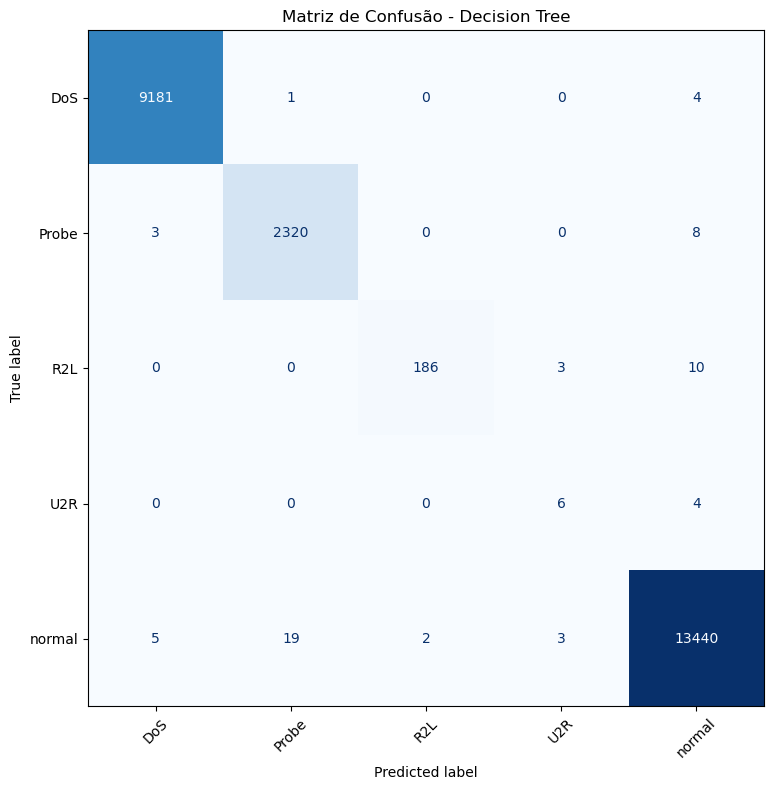

In [23]:
# Encoding para métricas
le = LabelEncoder()
y_val_enc = le.fit_transform(y_val)
y_pred_enc = le.transform(y_pred)

# Probabilidades para AUC
y_proba = best_dt.predict_proba(X_val)

# Métricas principais
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average='macro')
recall = recall_score(y_val, y_pred, average='macro')
f1 = f1_score(y_val, y_pred, average='macro')
rmse = np.sqrt(mean_squared_error(y_val_enc, y_pred_enc))

# Matriz de confusão para FPR e FNR
cm = confusion_matrix(y_val_enc, y_pred_enc)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

# Taxas derivadas
fpr = np.mean(FP / (FP + TN + 1e-10))
fnr = np.mean(FN / (FN + TP + 1e-10))
tpr = recall

# AUC
try:
    auc = roc_auc_score(y_val_enc, y_proba, multi_class='ovr', average='macro')
except Exception:
    auc = None

# Resultados
print("==== Avaliação Global (Decision Tree) ====")
print(f"Acurácia:         {accuracy:.4f}")
print(f"Precisão:         {precision:.4f}")
print(f"Recall (TPR):     {recall:.4f}")
print(f"F1-Score:         {f1:.4f}")
print(f"FPR (média):      {fpr:.4f}")
print(f"FNR (média):      {fnr:.4f}")
print(f"RMSE:             {rmse:.4f}")
print(f"AUC (ROC):        {auc:.4f}" if auc is not None else "AUC (ROC):        Não aplicável")

# Relatório detalhado
print("\n==== Relatório por Categoria ====")
print(classification_report(y_val, y_pred, digits=4))

# Matriz de confusão original
labels = sorted(y_val.unique())
cm = confusion_matrix(y_val, y_pred, labels=labels)

fig, ax = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap="Blues", xticks_rotation=45, ax=ax, colorbar=False)
plt.title("Matriz de Confusão - Decision Tree")
plt.grid(False)
plt.tight_layout()
plt.show()

==== Relatório Binário (normal vs attack) ====
              precision    recall  f1-score   support

      normal     0.9981    0.9978    0.9980     13469
      attack     0.9975    0.9978    0.9977     11726

    accuracy                         0.9978     25195
   macro avg     0.9978    0.9978    0.9978     25195
weighted avg     0.9978    0.9978    0.9978     25195



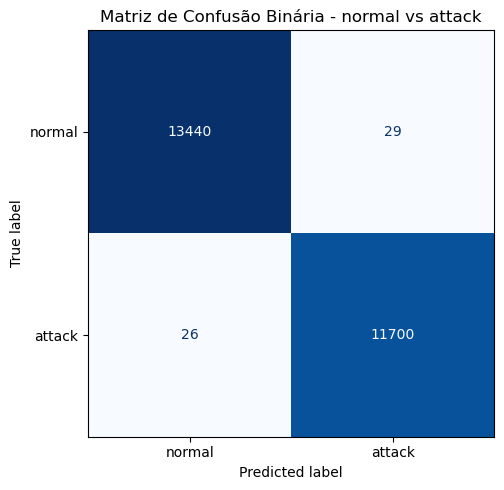

In [24]:
# Gera rótulos binários: 0 = normal, 1 = ataque
y_val_bin = y_val.apply(lambda x: 0 if x == "normal" else 1)
y_pred_bin = pd.Series(y_pred, index=y_val.index).apply(lambda x: 0 if x == "normal" else 1)

# Relatório binário
print("==== Relatório Binário (normal vs attack) ====")
print(classification_report(y_val_bin, y_pred_bin, target_names=["normal", "attack"], digits=4))

# Matriz de confusão binária
cm_bin = confusion_matrix(y_val_bin, y_pred_bin)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_bin, display_labels=["normal", "attack"])

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Blues", ax=ax, colorbar=False)
plt.title("Matriz de Confusão Binária - normal vs attack")
plt.grid(False)
plt.tight_layout()
plt.show()

### Teste com KDDTest+

In [25]:
# Modelo
best_dt = DecisionTreeClassifier(
    criterion='gini',
    max_depth=25,
    min_samples_leaf=3,
    min_samples_split=10,
    ccp_alpha=0.0,
    max_features=None
)

# Treinamento com base final e predição
best_dt.fit(X_train_final, y_train_final)
y_pred = best_dt.predict(X_test_final)

In [26]:
# Codificação para RMSE e AUC
le = LabelEncoder()
y_test_enc = le.fit_transform(y_test_final)
y_pred_enc = le.transform(y_pred)

# Probabilidades para AUC
y_proba = best_dt.predict_proba(X_test_final)

# Métricas principais
accuracy = accuracy_score(y_test_final, y_pred)
precision = precision_score(y_test_final, y_pred, average='macro')
recall = recall_score(y_test_final, y_pred, average='macro')
f1 = f1_score(y_test_final, y_pred, average='macro')
rmse = np.sqrt(mean_squared_error(y_test_enc, y_pred_enc))

# Matriz de confusão para FPR e FNR
cm = confusion_matrix(y_test_enc, y_pred_enc)
FP = cm.sum(axis=0) - np.diag(cm)
FN = cm.sum(axis=1) - np.diag(cm)
TP = np.diag(cm)
TN = cm.sum() - (FP + FN + TP)

fpr = np.mean(FP / (FP + TN + 1e-10))
fnr = np.mean(FN / (FN + TP + 1e-10))
tpr = recall

# AUC
try:
    auc = roc_auc_score(y_test_enc, y_proba, multi_class='ovr', average='macro')
except Exception:
    auc = None

# Resultados
print("==== Avaliação Global no Conjunto de Teste (Decision Tree) ====")
print(f"Acurácia:         {accuracy:.4f}")
print(f"Precisão:         {precision:.4f}")
print(f"Recall (TPR):     {recall:.4f}")
print(f"F1-Score:         {f1:.4f}")
print(f"FPR (média):      {fpr:.4f}")
print(f"FNR (média):      {fnr:.4f}")
print(f"RMSE:             {rmse:.4f}")
print(f"AUC (ROC):        {auc:.4f}" if auc is not None else "AUC (ROC):        Não aplicável")


==== Avaliação Global no Conjunto de Teste (Decision Tree) ====
Acurácia:         0.7647
Precisão:         0.7820
Recall (TPR):     0.5060
F1-Score:         0.5275
FPR (média):      0.0794
FNR (média):      0.4940
RMSE:             1.3372
AUC (ROC):        0.6861


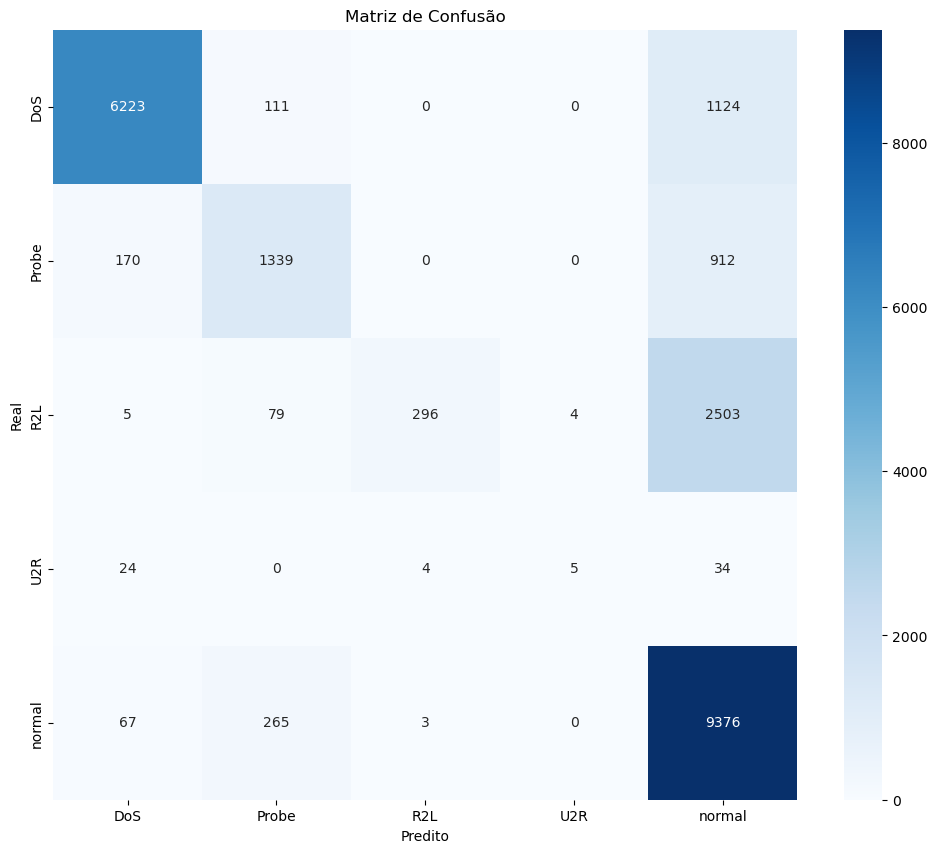

In [27]:
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [28]:
report = classification_report(y_test_final, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()


print(report_df)

              precision    recall  f1-score       support
DoS            0.959008  0.834406  0.892378   7458.000000
Probe          0.746377  0.553077  0.635350   2421.000000
R2L            0.976898  0.102529  0.185580   2887.000000
U2R            0.555556  0.074627  0.131579     67.000000
normal         0.672163  0.965503  0.792561   9711.000000
accuracy       0.764682  0.764682  0.764682      0.764682
macro avg      0.782000  0.506028  0.527490  22544.000000
weighted avg   0.813705  0.764682  0.729005  22544.000000
